<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.77 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 10:37:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 177 kB 59.0 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 138 kB 57.1 MB/s 
     |████████████████████████████████| 133 kB 56.0 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 872 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: tmut8ph8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/tmut8ph8


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: m5uz8276 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
31/31 [==============================] - 16s 29ms/step - loss: 0.1575 - mean_squared_error: 0.1575 - mean_absolute_error: 0.2840 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0971
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0590 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0913
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0574 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1008
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0495 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0796
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_err

epoch,97
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02675
val_loss,0.00349
val_mean_squared_error,0.00349
val_mean_absolute_error,0.04638
_runtime,49
_timestamp,1627036697
_step,97
best_val_loss,0.00341


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▃▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▄▃▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▄▄▆▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dxheq055 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 2s 20ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - mean_absolute_error: 0.2160 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1112
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0821
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0767
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0460 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0697
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0030 - mean_squared_erro

epoch,58
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02856
val_loss,0.00451
val_mean_squared_error,0.00451
val_mean_absolute_error,0.05202
_runtime,16
_timestamp,1627036719
_step,58
best_val_loss,0.00409


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▂▂▂▂▄▁▁▃▂▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▂▂▂▂▄▁▁▃▂▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▅▃▂▂▂▆▂▂▄▂▄▂▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m31c8okw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 73ms/step - loss: 0.2900 - mean_squared_error: 0.2900 - mean_absolute_error: 0.4653 - val_loss: 0.2077 - val_mean_squared_error: 0.2077 - val_mean_absolute_error: 0.3770
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2163 - mean_squared_error: 0.2163 - mean_absolute_error: 0.3903 - val_loss: 0.1292 - val_mean_squared_error: 0.1292 - val_mean_absolute_error: 0.2752
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1309 - mean_squared_error: 0.1309 - mean_absolute_error: 0.2941 - val_loss: 0.0670 - val_mean_squared_error: 0.0670 - val_mean_absolute_error: 0.2017
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - mean_absolute_error: 0.2134 - val_loss: 0.0468 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1976
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0437 - mean_squared_error: 0.04

epoch,99
loss,0.00305
mean_squared_error,0.00305
mean_absolute_error,0.04265
val_loss,0.01119
val_mean_squared_error,0.01119
val_mean_absolute_error,0.07874
_runtime,15
_timestamp,1627036741
_step,99
best_val_loss,0.01117


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2lvqo8lq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 68ms/step - loss: 0.2153 - mean_squared_error: 0.2153 - mean_absolute_error: 0.3943 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1145
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0873 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1092
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0660 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0910
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0573 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0844
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0

epoch,99
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02507
val_loss,0.00493
val_mean_squared_error,0.00493
val_mean_absolute_error,0.05584
_runtime,15
_timestamp,1627036764
_step,99
best_val_loss,0.00387


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,█▅▄▄▃▆▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁
val_mean_squared_error,█▅▄▄▃▆▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▆▅▄▄▆▃▃▃▃▄▂▂▂▃▂▂▂▂▂▂▁▃▂▃▂▁▂▁▁▃▂▁▁▁▁▂▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vcd0wzuq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 70ms/step - loss: 0.1334 - mean_squared_error: 0.1334 - mean_absolute_error: 0.2871 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1090
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1108 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1179
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1133 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1172
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1104 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1203
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0124 - mean_squared_error: 0.0124

epoch,39
loss,0.00473
mean_squared_error,0.00473
mean_absolute_error,0.0579
val_loss,0.01034
val_mean_squared_error,0.01034
val_mean_absolute_error,0.08198
_runtime,9
_timestamp,1627036791
_step,39
best_val_loss,0.00771


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▄▃▂▄▄▃▂▃▃▂▁▂▃▂▂▃▂▂▃▂▂▂▃▂▁▂▂▂▂▂▂▁▂▂▂
val_loss,▃▃▃▃▃█▂▃▄▃▃▂▃▂▂▁▃▁▂▂▁▁▂▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▃▃▃▃█▂▃▄▃▃▂▃▂▂▁▃▁▂▂▁▁▂▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▄▄▄▃█▂▄▅▄▃▂▄▂▃▁▄▂▂▃▂▂▂▂▁▃▂▂▁▁▂▂▁▁▁▁▁▂▂▂
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ltesqq6n with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.1262 - mean_squared_error: 0.1262 - mean_absolute_error: 0.2759 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1064
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1250 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0978
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0909 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1065
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1156 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1007
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0091 - mean_squared_error: 0.0091 -

epoch,47
loss,0.00428
mean_squared_error,0.00428
mean_absolute_error,0.05573
val_loss,0.00836
val_mean_squared_error,0.00836
val_mean_absolute_error,0.07197
_runtime,11
_timestamp,1627036809
_step,47
best_val_loss,0.00603


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▃▂▃▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▃▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▅▃▄▃▃▃▂▂▄▃▁▁▄▃▂▁▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▂▂▂▁▁▂
val_loss,▅▄▅▄▃▆▄▃▃▂█▃▂▂▂▅▃▂▁▄▂▃▄▂▁▃▂▂▂▂▂▁▁▃▂▂▂▁▁▂
val_mean_squared_error,▅▄▅▄▃▆▄▃▃▂█▃▂▂▂▅▃▂▁▄▂▃▄▂▁▃▂▂▂▂▂▁▁▃▂▂▂▁▁▂
val_mean_absolute_error,▅▅▅▅▄▆▄▄▄▂█▄▂▂▂▅▄▂▂▅▂▃▄▂▂▃▂▂▂▂▂▁▁▄▃▃▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: y33w37ru with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 19ms/step - loss: 0.3280 - mean_squared_error: 0.3280 - mean_absolute_error: 0.2799 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1952
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1466 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0760
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1029 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0683
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0598 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1142
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0111 - mean_squared_error: 0.

epoch,24
loss,0.00288
mean_squared_error,0.00288
mean_absolute_error,0.0385
val_loss,0.00401
val_mean_squared_error,0.00401
val_mean_absolute_error,0.04844
_runtime,11
_timestamp,1627036830
_step,24
best_val_loss,0.00381


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▃▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▃▃▁▁▁▅▁▁▂▁▃▁▃▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▂▂▃▃▁▁▁▅▁▁▂▁▃▁▃▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▂▂▄▄▂▁▁▆▂▁▃▁▃▁▄▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: m72pjo0b with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.0671 - mean_squared_error: 0.0671 - mean_absolute_error: 0.1766 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1011
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0919
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0501 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0890
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0448 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0833
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_erro

epoch,99
loss,0.0007
mean_squared_error,0.0007
mean_absolute_error,0.02007
val_loss,0.00345
val_mean_squared_error,0.00345
val_mean_absolute_error,0.04505
_runtime,26
_timestamp,1627036866
_step,99
best_val_loss,0.00343


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ifspzfbq with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 3s 24ms/step - loss: 2.1051 - mean_squared_error: 2.1051 - mean_absolute_error: 0.8812 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1161
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0859 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0579
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0585 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0600
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.0573 - val_loss: 10.1545 - val_mean_squared_error: 10.1545 - val_mean_absolute_error: 3.0027
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 3.4881 - mean_squared_er

epoch,20
loss,0.00456
mean_squared_error,0.00456
mean_absolute_error,0.04366
val_loss,0.00522
val_mean_squared_error,0.00522
val_mean_absolute_error,0.05377
_runtime,13
_timestamp,1627036909
_step,20
best_val_loss,0.00379


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
mean_squared_error,▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
mean_absolute_error,▃▁▁▂▄▁▁▁▁▁▁▁▁▁▁▁▁█▄▂▁
val_loss,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁
val_mean_squared_error,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁
val_mean_absolute_error,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁
_runtime,▁▁▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: y7wk456h with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 38ms/step - loss: 0.1662 - mean_squared_error: 0.1662 - mean_absolute_error: 0.3133 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0958
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0551 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0879
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0798
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0765
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0

epoch,49
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03472
val_loss,0.00996
val_mean_squared_error,0.00996
val_mean_absolute_error,0.08205
_runtime,15
_timestamp,1627036934
_step,49
best_val_loss,0.00443


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val_loss,█▆▅▄▄▃▆▃▃▃▂▂▂▂▂█▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▃▁▁▂▁▁▁▁▄
val_mean_squared_error,█▆▅▄▄▃▆▃▃▃▂▂▂▂▂█▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▃▁▁▂▁▁▁▁▄
val_mean_absolute_error,█▆▅▅▄▄▇▃▃▃▃▃▃▃▂█▂▂▂▂▃▂▂▂▂▂▂▂▂▃▁▃▁▂▃▁▁▁▁▆
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2rr50tgm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 19ms/step - loss: 0.1966 - mean_squared_error: 0.1966 - mean_absolute_error: 0.3726 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1749
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1615 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1677
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1412 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1513
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1261 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1389
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0161 - mean_squared_erro

epoch,99
loss,0.00269
mean_squared_error,0.00269
mean_absolute_error,0.03992
val_loss,0.01008
val_mean_squared_error,0.01008
val_mean_absolute_error,0.07558
_runtime,26
_timestamp,1627036969
_step,99
best_val_loss,0.00991


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5zlypz8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 2s 20ms/step - loss: 0.1929 - mean_squared_error: 0.1929 - mean_absolute_error: 0.3647 - val_loss: 0.0544 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1993
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1581 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1620
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1362 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1411
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1102 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1209
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0097 - mean_squared_erro

epoch,199
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.03001
val_loss,0.00638
val_mean_squared_error,0.00638
val_mean_absolute_error,0.06051
_runtime,50
_timestamp,1627037047
_step,199
best_val_loss,0.00635


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4hwhm8lj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 2s 21ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1750 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1122
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0913
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0465 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0690
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0404 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0592
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_erro

epoch,55
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.02077
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04667
_runtime,19
_timestamp,1627037076
_step,55
best_val_loss,0.00289


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▃▂▁▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁
val_loss,█▆▃▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▄▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▃▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o6i5m942 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 24ms/step - loss: 0.2039 - mean_squared_error: 0.2039 - mean_absolute_error: 0.2626 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0978
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1191 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0810
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0809 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0959
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0728 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1531
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_squared_error: 0.

epoch,39
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03794
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.05962
_runtime,16
_timestamp,1627037106
_step,39
best_val_loss,0.00319


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▄█▂▅▂▁▂▁▃▂▁▂▂▂▁▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▄▃▄█▂▅▂▁▂▁▃▂▁▂▂▂▁▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▄▃▄█▂▅▂▁▂▁▃▃▁▂▃▃▁▃▂▃▂▁▃▁▂▁▂▃▂▁▂▁▂▁▂▁▁▁▂▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dcfyb6qq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 70ms/step - loss: 0.1885 - mean_squared_error: 0.1885 - mean_absolute_error: 0.3588 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1173
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0807 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1072
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0638 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1158
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0622 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1098
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0054 - mean_squared_error: 0.005

epoch,60
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02687
val_loss,0.00753
val_mean_squared_error,0.00753
val_mean_absolute_error,0.06825
_runtime,12
_timestamp,1627037128
_step,60
best_val_loss,0.00506


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▅▅▅▃▃▃▃▂▂▃▃▂▃▂▄▂▂▂▂▂▂▁▁▂▁▁▃▁▁▁▁▂▁▂▂▁▂
val_mean_squared_error,█▇█▅▅▅▃▃▃▃▂▂▃▃▂▃▂▄▂▂▂▂▂▂▁▁▂▁▁▃▁▁▁▁▂▁▂▂▁▂
val_mean_absolute_error,█▇▇▆▄▅▄▃▃▃▂▂▃▃▃▃▃▅▂▂▂▃▂▂▁▁▂▁▁▄▂▂▂▁▃▁▂▂▂▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yvn1768z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_error: 0.1940 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1094
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0766 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0822
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0615 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0800
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0716 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1006
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.

epoch,49
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03556
val_loss,0.00695
val_mean_squared_error,0.00695
val_mean_absolute_error,0.06747
_runtime,18
_timestamp,1627037156
_step,49
best_val_loss,0.00356


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁
val_loss,▇▄▄▆██▂▂▂▄▂▂▂▃▂▂▁▃▂▁▁▂▂▁▁▁▁▂▁▁▂▂▁▂▁▁▁▁▁▂
val_mean_squared_error,▇▄▄▆██▂▂▂▄▂▂▂▃▂▂▁▃▂▁▁▂▂▁▁▁▁▂▁▁▂▂▁▂▁▁▁▁▁▂
val_mean_absolute_error,▇▅▄▆██▃▃▂▄▂▃▃▃▃▂▂▃▂▂▁▂▃▂▁▁▂▂▁▁▂▃▁▂▁▁▁▁▁▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 34gfdugw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.9395 - mean_squared_error: 0.9395 - mean_absolute_error: 0.5270 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1135
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1060 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1057
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.0912 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0911
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0595 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1383
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0148 - mean_squared_error: 0.

epoch,36
loss,0.00354
mean_squared_error,0.00354
mean_absolute_error,0.04676
val_loss,0.00618
val_mean_squared_error,0.00618
val_mean_absolute_error,0.06441
_runtime,12
_timestamp,1627037187
_step,36
best_val_loss,0.00371


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▅▂▄▂▄▂▃▁▂▃▂▃▁▃▁▂▂▃▁▂▂▃▁▂▃▁▂▃▁▂▁▂
val_loss,▂▂▁▂▁▁▂▁▁▃▁▂▁▂▁█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▁▂▁▁▂▁▁▃▁▂▁▂▁█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▃▂▁▂▂▁▄▂▂▁▂▁█▁▂▁▁▁▃▁▁▂▂▁▁▁▁▁▂▁▁▂▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7m4ibpor with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 0.1631 - mean_squared_error: 0.1631 - mean_absolute_error: 0.3235 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1561
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1120 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0901
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0866
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0864
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.

epoch,49
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02899
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.05704
_runtime,18
_timestamp,1627037216
_step,49
best_val_loss,0.00586


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pcsy08ig with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.1524 - mean_squared_error: 0.1524 - mean_absolute_error: 0.3129 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1131
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0952 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1372
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0745 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1050
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0553 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0938
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_erro

epoch,99
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01865
val_loss,0.0031
val_mean_squared_error,0.0031
val_mean_absolute_error,0.04214
_runtime,21
_timestamp,1627037246
_step,99
best_val_loss,0.00301


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1sbthkcc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 25ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1517 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0954
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0585 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0840
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0756
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0525 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0685
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,82
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.0187
val_loss,0.00394
val_mean_squared_error,0.00394
val_mean_absolute_error,0.04753
_runtime,32
_timestamp,1627037293
_step,82
best_val_loss,0.00313


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▂▃▂▂▂▃▁▁▂▂▂▁▂▁▂▂▂▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁
val_loss,█▅▄▄▂▃▂▂▃▃▂▃▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▂▃▂▂▃▃▂▃▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▃▄▃▂▅▄▂▃▂▁▁▁▂▁▁▁▁▁▂▂▁▂▁▂▁▄▁▁▁▂▂▂▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7fi4c3az with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 72ms/step - loss: 1.3506 - mean_squared_error: 1.3506 - mean_absolute_error: 0.7278 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0999
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0587 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0927
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0521 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0914
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0852 - mean_squared_error: 0.0852 - mean_absolute_error: 0.2231 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0909
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - 

epoch,49
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.03451
val_loss,0.00548
val_mean_squared_error,0.00548
val_mean_absolute_error,0.05822
_runtime,11
_timestamp,1627037327
_step,49
best_val_loss,0.00409


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▄▃▂▂▄▂▂▄▁▄▂▁▂▃▂▁▂▃▂▁▁▁▂▃▁▁▂▂▁▁▁▁▂▂▂▁▁
val_loss,▂▂▂▂▄▁▇▁▂▃▁▁▄▁▁▁▂▁▁▁█▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▄▁▁▁
val_mean_squared_error,▂▂▂▂▄▁▇▁▂▃▁▁▄▁▁▁▂▁▁▁█▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▄▁▁▁
val_mean_absolute_error,▃▂▂▂▅▂█▂▂▅▂▁▅▁▁▂▃▁▁▁█▁▁▃▂▃▁▁▂▃▁▂▁▁▂▂▅▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bnb5i5mn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 71ms/step - loss: 0.1985 - mean_squared_error: 0.1985 - mean_absolute_error: 0.3641 - val_loss: 0.0522 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1948
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1664 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0856
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0670 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0647
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0511 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0632
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - me

epoch,49
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01957
val_loss,0.00293
val_mean_squared_error,0.00293
val_mean_absolute_error,0.04177
_runtime,13
_timestamp,1627037351
_step,49
best_val_loss,0.00292


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: s558mms4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 2s 70ms/step - loss: 0.2205 - mean_squared_error: 0.2205 - mean_absolute_error: 0.3769 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1125
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0788 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0980
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0656 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0957
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0642 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0878
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 

epoch,68
loss,0.00317
mean_squared_error,0.00317
mean_absolute_error,0.04628
val_loss,0.00682
val_mean_squared_error,0.00682
val_mean_absolute_error,0.06462
_runtime,14
_timestamp,1627037379
_step,68
best_val_loss,0.00558


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅█▅▅▆▆▄▃▄▂▃▆▃▂▂▂▃▂▃▃▂▂▅▃▁▂▃▂▂▄▁▂▃▂▂▁▁▁
val_mean_squared_error,█▆▅█▅▅▆▆▄▃▄▂▃▆▃▂▂▂▃▂▃▃▂▂▅▃▁▂▃▂▂▄▁▂▃▂▂▁▁▁
val_mean_absolute_error,█▆▅█▅▅▆▅▃▃▃▂▃▇▃▂▂▂▃▂▄▄▂▂▆▄▁▂▄▂▂▅▁▃▃▂▃▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t21wte8t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 24ms/step - loss: 0.2244 - mean_squared_error: 0.2244 - mean_absolute_error: 0.3908 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1753
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1485 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1595
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1303 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1437
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1151 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1302
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0135 - mean_squared_error: 0.

epoch,49
loss,0.00338
mean_squared_error,0.00338
mean_absolute_error,0.0449
val_loss,0.01221
val_mean_squared_error,0.01221
val_mean_absolute_error,0.08249
_runtime,19
_timestamp,1627037409
_step,49
best_val_loss,0.01221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sg0vie8x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 34ms/step - loss: 0.2126 - mean_squared_error: 0.2126 - mean_absolute_error: 0.3747 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1880
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1493 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1314
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0882 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0920
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0895
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.

epoch,49
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.03103
val_loss,0.00638
val_mean_squared_error,0.00638
val_mean_absolute_error,0.06043
_runtime,14
_timestamp,1627037442
_step,49
best_val_loss,0.00634


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ze4w1vhu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 72ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.2052 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1139
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0649 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1071
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0897
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0843
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.00

epoch,99
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.02006
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04612
_runtime,19
_timestamp,1627037474
_step,99
best_val_loss,0.00352


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: og7c2h1h with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 1.8033 - mean_squared_error: 1.8033 - mean_absolute_error: 1.1368 - val_loss: 0.0953 - val_mean_squared_error: 0.0953 - val_mean_absolute_error: 0.2656
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2435 - mean_squared_error: 0.2435 - mean_absolute_error: 0.3798 - val_loss: 0.1460 - val_mean_squared_error: 0.1460 - val_mean_absolute_error: 0.3333
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1579 - mean_squared_error: 0.1579 - mean_absolute_error: 0.3299 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0850
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0778 - val_loss: 0.0829 - val_mean_squared_error: 0.0829 - val_mean_absolute_error: 0.2631
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0411 - mean_squared_error: 0.0411 -

epoch,17
loss,0.03693
mean_squared_error,0.03693
mean_absolute_error,0.15115
val_loss,0.01116
val_mean_squared_error,0.01116
val_mean_absolute_error,0.08124
_runtime,10
_timestamp,1627037506
_step,17
best_val_loss,0.00678


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,▆▂▂▁▁▁▁▁▁▁▁▁▁█▃▂▁▁
mean_squared_error,▆▂▂▁▁▁▁▁▁▁▁▁▁█▃▂▁▁
mean_absolute_error,▇▃▃▂▂▁▁▁▁▁▁▁▂█▅▃▂▂
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁
val_mean_absolute_error,▂▂▁▂▁▁▁▁▁▁▁▁█▃▂▂▂▁
_runtime,▁▁▁▁▅▅▅▅▅▅▅███████
_timestamp,▁▁▁▁▅▅▅▅▅▅▅███████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: iklj3cmn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 38ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - mean_absolute_error: 0.1878 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1302
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1198 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0930
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0955 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0771
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0738 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0741
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_er

epoch,84
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02161
val_loss,0.00289
val_mean_squared_error,0.00289
val_mean_absolute_error,0.04074
_runtime,23
_timestamp,1627037541
_step,84
best_val_loss,0.00286


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▅▃▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3axs1l46 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 24ms/step - loss: 0.0979 - mean_squared_error: 0.0979 - mean_absolute_error: 0.2393 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0612
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0605 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - val_mean_absolute_error: 0.2741
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1238 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0538
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0369 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0667
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_

epoch,48
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02399
val_loss,0.0029
val_mean_squared_error,0.0029
val_mean_absolute_error,0.04102
_runtime,24
_timestamp,1627037577
_step,48
best_val_loss,0.0028


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▂▃▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▇▂▃▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▂▂▂▁▇▂▁▂▁▁▁▁▂▁▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂█▁▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ix5ohduz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 0.1698 - mean_squared_error: 0.1698 - mean_absolute_error: 0.3268 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1063
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0639 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0922
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0560 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0880
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0866
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_e

epoch,44
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.03009
val_loss,0.00437
val_mean_squared_error,0.00437
val_mean_absolute_error,0.05107
_runtime,16
_timestamp,1627037605
_step,44
best_val_loss,0.00411


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,▇▆▅▅▄▄▄█▃▃▆▂▂▃▂▂▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▆▅▅▄▄▄█▃▃▆▂▂▃▂▂▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▅▅▅▅▄█▃▃▆▂▂▄▂▂▃▃▁▂▁▂▁▂▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: on62c1g2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 23ms/step - loss: 0.1266 - mean_squared_error: 0.1266 - mean_absolute_error: 0.2733 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1161
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1493 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1535
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1189 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1157
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1101 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1033
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0134 - mean_squared_erro

epoch,58
loss,0.00236
mean_squared_error,0.00236
mean_absolute_error,0.03772
val_loss,0.01191
val_mean_squared_error,0.01191
val_mean_absolute_error,0.08952
_runtime,23
_timestamp,1627037641
_step,58
best_val_loss,0.0038


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▃▂▃█▂▂▄▁▂▂▃▄▃▂▁▁▂▂▁▁▃▃▂▁▁▃▁▁▂▁▁▂▁▁▂▁▃
val_mean_squared_error,▅█▅▃▂▃█▂▂▄▁▂▂▃▄▃▂▁▁▂▂▁▁▃▃▂▁▁▃▁▁▂▁▁▂▁▁▂▁▃
val_mean_absolute_error,▅█▅▄▃▄█▃▂▄▂▂▂▄▅▄▂▂▁▂▂▂▂▃▄▂▁▁▄▁▁▂▁▁▂▁▁▂▁▄
_runtime,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 76rcrgyc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 62ms/step - loss: 0.2496 - mean_squared_error: 0.2496 - mean_absolute_error: 0.4255 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1408
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1511 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1526
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1084 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1235
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0966 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1472
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - m

epoch,49
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02433
val_loss,0.00488
val_mean_squared_error,0.00488
val_mean_absolute_error,0.05267
_runtime,13
_timestamp,1627037668
_step,49
best_val_loss,0.00488


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅█▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅█▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆█▅▄▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 88sywmh3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 39ms/step - loss: 0.1395 - mean_squared_error: 0.1395 - mean_absolute_error: 0.2875 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1043
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0616 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1146
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0614 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0875
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1132
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_e

epoch,99
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.02188
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04487
_runtime,29
_timestamp,1627037714
_step,99
best_val_loss,0.00348


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▃▂▁▂▂▂▁▂▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▄▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁
val_mean_squared_error,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▄▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁
val_mean_absolute_error,█▆▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▅▂▁▂▂▂▂▁▂▁▁▁▂▂▁▁▃▁▁▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0at93csv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 36ms/step - loss: 0.2216 - mean_squared_error: 0.2216 - mean_absolute_error: 0.3849 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1048
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1287 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0955
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1147 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0977
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1140 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1753
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0236 - mean_squared_erro

epoch,27
loss,0.005
mean_squared_error,0.005
mean_absolute_error,0.05823
val_loss,0.02223
val_mean_squared_error,0.02223
val_mean_absolute_error,0.11604
_runtime,13
_timestamp,1627037740
_step,27
best_val_loss,0.00705


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▂▁▁▁▂▁▁
val_loss,▃▂▃▇▂▅▆▇▄▃▂▃▂█▁▁▁▁▂▁▂▁▄▂▁▂▂▃
val_mean_squared_error,▃▂▃▇▂▅▆▇▄▃▂▃▂█▁▁▁▁▂▁▂▁▄▂▁▂▂▃
val_mean_absolute_error,▃▃▃▇▃▅▆▇▄▃▂▄▂█▁▂▂▁▃▁▂▁▅▂▁▂▂▄
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 0kz6jdio with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 73ms/step - loss: 0.2030 - mean_squared_error: 0.2030 - mean_absolute_error: 0.3727 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.2099
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1790 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1618
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1388 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1384
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.1015 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1101
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0075 - mean_squared_error: 0.0

epoch,99
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02987
val_loss,0.00654
val_mean_squared_error,0.00654
val_mean_absolute_error,0.06134
_runtime,20
_timestamp,1627037773
_step,99
best_val_loss,0.00653


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kc3wjdpy with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 75ms/step - loss: 3.2432 - mean_squared_error: 3.2432 - mean_absolute_error: 1.3410 - val_loss: 0.4759 - val_mean_squared_error: 0.4759 - val_mean_absolute_error: 0.5986
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.3846 - mean_squared_error: 0.3846 - mean_absolute_error: 0.5060 - val_loss: 0.1070 - val_mean_squared_error: 0.1070 - val_mean_absolute_error: 0.2759
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: 0.1515 - mean_squared_error: 0.1515 - mean_absolute_error: 0.3165 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2280
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1502 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1414
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0148 - mean_squared_error: 0.0

epoch,18
loss,0.00481
mean_squared_error,0.00481
mean_absolute_error,0.05266
val_loss,0.00662
val_mean_squared_error,0.00662
val_mean_absolute_error,0.06168
_runtime,11
_timestamp,1627037797
_step,18
best_val_loss,0.00509


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▃▅▃▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▃▅▃▁▁▁▁
mean_absolute_error,█▃▃▂▁▁▁▁▁▁▁▁▄▆▅▃▂▂▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁█▇▁▁▁▁▁
val_mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁█▇▁▁▁▁▁
val_mean_absolute_error,▃▂▂▁▁▁▁▁▁▁▁▁█▇▂▁▁▁▁
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: z09lofy7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 34ms/step - loss: 0.1240 - mean_squared_error: 0.1240 - mean_absolute_error: 0.2401 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0972
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0562 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0819
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0437 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0777
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0400 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0747
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0

epoch,49
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02695
val_loss,0.00571
val_mean_squared_error,0.00571
val_mean_absolute_error,0.05758
_runtime,16
_timestamp,1627037826
_step,49
best_val_loss,0.0057


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zlbjopcr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 4.9576 - mean_squared_error: 4.9576 - mean_absolute_error: 1.3704 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0768
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0387 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0544
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0286 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0643
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0429 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0583
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.

epoch,24
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02462
val_loss,0.00286
val_mean_squared_error,0.00286
val_mean_absolute_error,0.04088
_runtime,15
_timestamp,1627037856
_step,24
best_val_loss,0.0028


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▄▅▂▂▂▁▁▁▂▂▁▁▂▂▂▁▁▂▁▁▂▁
val_mean_squared_error,█▃▄▄▅▂▂▂▁▁▁▂▂▁▁▂▂▂▁▁▂▁▁▂▁
val_mean_absolute_error,█▄▆▄▆▂▂▃▁▂▁▂▂▁▁▂▂▂▁▁▃▂▁▂▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: qv2ivwl8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 69ms/step - loss: 0.2022 - mean_squared_error: 0.2022 - mean_absolute_error: 0.3735 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1573
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1600 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1066
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0972 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1011
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0838 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0776
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034 -

epoch,49
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02449
val_loss,0.00387
val_mean_squared_error,0.00387
val_mean_absolute_error,0.0467
_runtime,15
_timestamp,1627037884
_step,49
best_val_loss,0.00387


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁
mean_squared_error,█▃▂▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▂▂▁▁▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▄▁▁▁
val_loss,█▄▄▂▂▂▂▂▂▁▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▄▄▂▂▂▂▂▂▁▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▂▂▂▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jewodk4w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 23ms/step - loss: 0.1780 - mean_squared_error: 0.1780 - mean_absolute_error: 0.3400 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1119
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0829 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0939
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0873
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0837
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.

epoch,49
loss,0.00066
mean_squared_error,0.00066
mean_absolute_error,0.01942
val_loss,0.00335
val_mean_squared_error,0.00335
val_mean_absolute_error,0.04379
_runtime,22
_timestamp,1627037920
_step,49
best_val_loss,0.00335


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p28e5q92 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 0.4763 - mean_squared_error: 0.4763 - mean_absolute_error: 0.5352 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1310
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1010 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0843
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0855
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0828
Epoch 5/50
8/8 [==============================] - 1s 98ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - m

epoch,49
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.0225
val_loss,0.00393
val_mean_squared_error,0.00393
val_mean_absolute_error,0.0485
_runtime,14
_timestamp,1627037954
_step,49
best_val_loss,0.00392


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ox9xcgzb with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 0.3169 - mean_squared_error: 0.3169 - mean_absolute_error: 0.2715 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0991
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0794 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1549
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1470 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0857
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0991 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0826
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.

epoch,20
loss,0.00292
mean_squared_error,0.00292
mean_absolute_error,0.04045
val_loss,0.00942
val_mean_squared_error,0.00942
val_mean_absolute_error,0.07692
_runtime,14
_timestamp,1627037985
_step,20
best_val_loss,0.00429


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▄▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_loss,▄█▃▃▃▂▁▁▂▃▁▁▂▁▁▁▁▂▁▄▂
val_mean_squared_error,▄█▃▃▃▂▁▁▂▃▁▁▂▁▁▁▁▂▁▄▂
val_mean_absolute_error,▄█▃▃▃▃▂▂▂▄▁▂▃▁▁▁▁▂▁▅▃
_runtime,▁▂▂▂▂▃▃▃▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 2lt9v7ir with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 74ms/step - loss: 0.2306 - mean_squared_error: 0.2306 - mean_absolute_error: 0.4062 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1197
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1395 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1220
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0973 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1150
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0866 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1328
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081 -

epoch,49
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02333
val_loss,0.00497
val_mean_squared_error,0.00497
val_mean_absolute_error,0.05268
_runtime,14
_timestamp,1627038023
_step,49
best_val_loss,0.00497


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇▆█▅▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▇▆█▅▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▇▆█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c1ydidqn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
39/39 [==============================] - 1s 4ms/step - loss: 2.2243
Epoch 2/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 3/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 5/50
39/39 [==============================] - 0s 3ms/step - loss: 8.2438e-04
Epoch 6/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 7/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 8/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 9/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 11/50
39/39 [==============================] - 0s 4ms/step - loss: 8.3425e-04
Epoch 12/50
39/39 [==============================] - 0s 3ms/step - loss: 7.0765e-04
Epoch 13/50
39/39 [==================

In [20]:
model.output_shape

(None, 1)

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

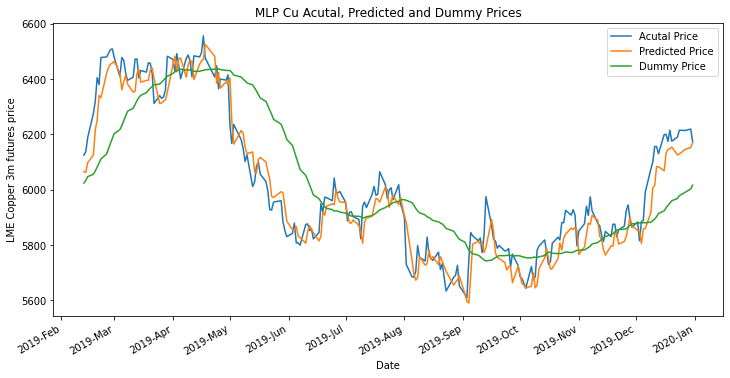

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

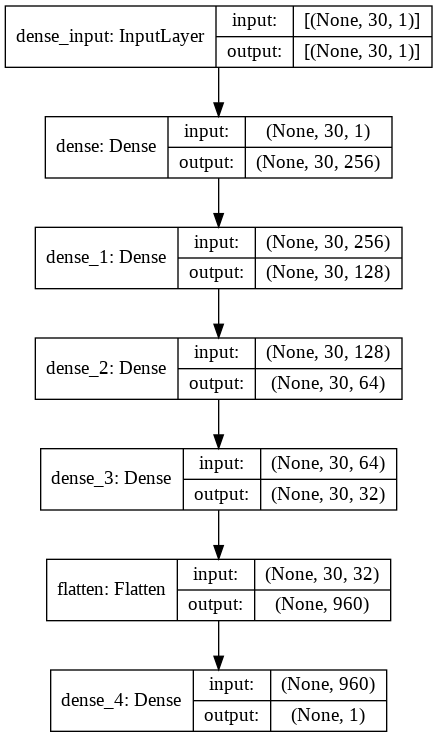

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004757830146349917
RMSE:  0.06897702622141605
MAE:  0.05492569860680011
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_Cu/assets
